# Starbucks Offer Personalization

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

One of the available dataset contains transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Challenge

Given the rules and exceptions for offer completion as illustrated in the example, the data cleaning and feature engineering part becomes especially important and tricky. 

The key part of the project is summarizing each customer's transaction behaviors from the chronological activity log to attribute the right transactions to the right offer types and track down their conversions for different offers on the user level. Those engineered features will then be combined with the user profile information such as income, age, gender and when their membership started to provide a wholistic view of each customer. 

My goal for this project is to use those demographic and behavioral features to predict what the best effective offer type is for each individual customers. Also I want to see whether there are any distinct subgroups within the entire customer base that exhibit certain patterns of demographics and buying behaviors, which set them apart from one another.


### Road Map
#### 1. Exploratary Analysis: 
Understand the three datasets
#### 2. Feature Engineering: 
Create attributes from the transaction log on the user level
#### 3. Machine Learning: 
Build multioutput classification model to determine the offer types ranked by likelihood of conversion
#### 4. Clustering: 
Find subgroups within customers that Starbucks can target differently according to each group's distinct demographical or behavioral patterns. 

## Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Exploratory Analysis

### a. portfolio data

In [2]:
portfolio = pd.DataFrame(portfolio)
portfolio.head(20)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
portfolio.offer_type.value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

In [4]:
mkt_channels = portfolio['channels'].str.join(',').str.get_dummies(',')
portfolio = pd.concat([portfolio, mkt_channels], axis = 1)
portfolio.drop(['channels'], axis = 1, inplace = True)

In [5]:
portfolio.head()

,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


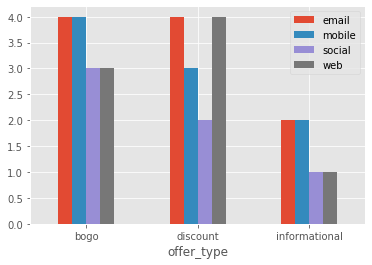

In [6]:
# distribution of channels for diff offers
portfolio.groupby('offer_type')['email','mobile','social','web'].sum().plot.bar(rot= 0 )

### b. profile data

In [7]:
#profile = pd.read_json('data/profile.json', orient='records', lines=True)
profile = pd.DataFrame(profile)
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [8]:
profile.shape

(17000, 5)

In [9]:
profile.isnull().sum() #2175 out of 17000 customers dont have info on gender and income

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

Text(0.5, 1.0, 'Age Distribution')

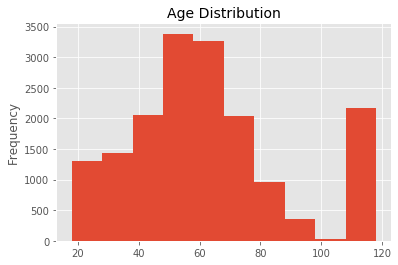

In [10]:
# age distribution
profile.age.plot.hist()
plt.title('Age Distribution', fontsize = 14)

In [11]:
profile.age[profile.age>=100].value_counts() 
# age outliers. guess all the customers who did not input income and gender are filled with age = 118
# set them to null then impute them with median age

118    2175
100      12
101       5
Name: age, dtype: int64

In [12]:
profile.age[profile.age>=100] = np.nan
# impute missing age
median_age = profile.age.median()
profile.age = profile.age.fillna(median_age)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


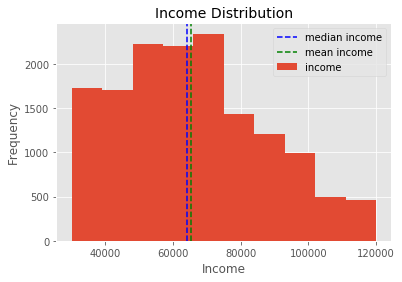

In [13]:
# income distribution
profile.income.plot.hist()
plt.axvline(profile['income'].median(), color = 'blue', linestyle = '--', label = 'median income')
plt.axvline(profile['income'].mean(), color = 'green', linestyle = '--', label = 'mean income')
plt.title('Income Distribution', fontsize = 14)
plt.xlabel('Income')
plt.legend()

Text(0.5, 1.0, 'Gender Distribution')

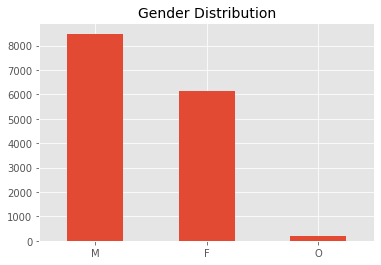

In [14]:
# gender distribution
profile.gender.value_counts().plot.bar(rot=0)
plt.title('Gender Distribution', fontsize = 14)
# more male customers than female 

In [15]:
# become member on - member tenure
profile.became_member_on = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile['member_since_year'] = profile['became_member_on'].dt.year

Text(0.5, 1.0, 'Start Year of Membership')

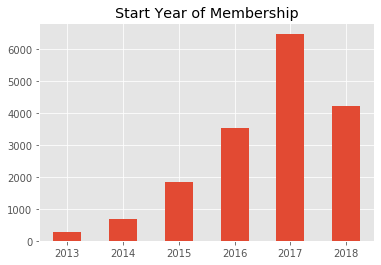

In [16]:
profile['member_since_year'].value_counts().sort_index().plot.bar(rot=0)
plt.title('Start Year of Membership')

Text(0.5, 1.0, 'Membership Growth Over Year by Gender')

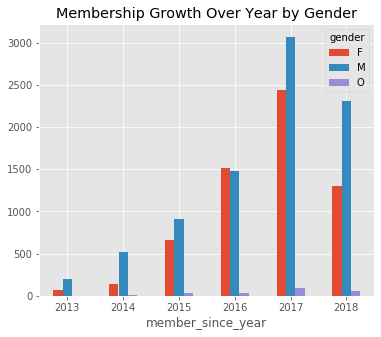

In [17]:
profile.groupby('member_since_year')['gender'].value_counts().unstack().sort_index().plot.bar(figsize=(6,5), rot=0)
plt.title('Membership Growth Over Year by Gender')

In [18]:
# assume the data is a snapshot of end of 2018. get member tenure by number of month
profile['member_tenure'] = round(((pd.to_datetime('20181231', format='%Y%m%d')) - profile['became_member_on'])/np.timedelta64(1, 'M'))

Text(0.5, 1.0, 'member tenure by month')

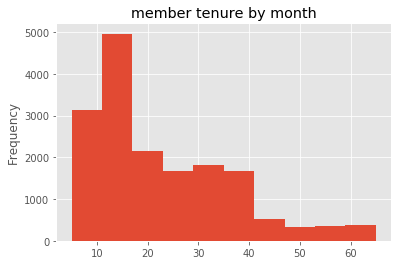

In [19]:
profile['member_tenure'].plot.hist(rot=0)
plt.title('member tenure by month')

### c. transcript data

In [20]:
transcript = pd.DataFrame(transcript)
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [21]:
transcript.shape

(306534, 4)

In [22]:
transcript.person.unique().shape[0] # 17k unique users = 17k unique customers in profile

17000

In [23]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [24]:
# value col is json format, what are diff key value pairs?
value_keys = []
for i in range(transcript.shape[0]):
    if transcript.value[i].keys() not in value_keys:
        value_keys.append(transcript.value[i].keys())
value_keys

[dict_keys(['offer id']),
 dict_keys(['amount']),
 dict_keys(['offer_id', 'reward'])]

In [25]:
# parse the json format of value column to individual columns
transcript = pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)

# offer_id shows in two separate columns due to the two different key types. 
#create new column to combine the two offer_id columns
transcript['offer_id_new']=np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(),transcript['offer_id'],transcript['offer id'])

#drop unnecessary offer_id columns
transcript.drop(['offer id','offer_id'],axis=1,inplace=True)

#rename offer_id column
transcript.rename(columns={'offer_id_new':'offer_id'},inplace=True)

In [26]:
transcript.head()

,event,person,time,value,amount,reward,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [27]:
print('Events where an offer is received and used')
print(transcript.loc[(transcript['offer_id'].notnull()) & (transcript['reward'].notnull()),'event'].value_counts())
print('\n')
print('Events where an offer is received but not used')
print(transcript.loc[(transcript['offer_id'].notnull()) & (transcript['reward'].isnull()),'event'].value_counts())
print('\n')
print('Events where transaction amount occurs')
print(transcript.loc[(transcript['amount'].notnull()) ,'event'].value_counts())

Events where an offer is received and used
offer completed    33579
Name: event, dtype: int64


Events where an offer is received but not used
offer received    76277
offer viewed      57725
Name: event, dtype: int64


Events where transaction amount occurs
transaction    138953
Name: event, dtype: int64


In [28]:
#rename column id since it really means offer id 
portfolio.rename(columns={'id':'offer_id'},inplace=True)

#join transcript with portfolio to get offer type
transcript_new = transcript.merge(portfolio,how='left',on='offer_id')

transcript_new.groupby(['event','offer_type'])['offer_type'].count()

event            offer_type   
offer completed  bogo             15669
                 discount         17910
offer received   bogo             30499
                 discount         30543
                 informational    15235
offer viewed     bogo             25449
                 discount         21445
                 informational    10831
Name: offer_type, dtype: int64

In [29]:
transcript_new.drop('value', axis=1, inplace=True)
transcript_new.head()

,event,person,time,amount,reward_x,offer_id,difficulty,duration,offer_type,reward_y,email,mobile,social,web
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0


In [30]:
transcript_new.rename(columns={'reward_x':'reward_received', 'reward_y':'reward_defined'},inplace=True)
transcript_new.reward_received.value_counts()

5.0     12070
2.0      9334
10.0     7019
3.0      5156
Name: reward_received, dtype: int64

In [31]:
transcript_new.loc[transcript_new['event']=='offer completed', 'person'].head(3)

12658    9fa9ae8f57894cc9a3b8a9bbe0fc1b2f
12672    fe97aa22dd3e48c8b143116a8403dd52
12679    629fc02d56414d91bca360decdfa9288
Name: person, dtype: object

In [32]:
# check one person's journey
transcript_new.loc[transcript_new.person =='9fa9ae8f57894cc9a3b8a9bbe0fc1b2f',:].sort_index().head(14)

,event,person,time,amount,reward_received,offer_id,difficulty,duration,offer_type,reward_defined,email,mobile,social,web
36,offer received,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0
12656,offer viewed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,NaN,2.0,2906b810c7d4411798c6938adc9daaa5,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0
27850,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,42,21.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44327,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,114,32.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51350,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,156,19.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65854,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,168,20.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81403,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,204,31.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110866,offer received,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,336,NaN,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,7.0,7.0,discount,3.0,1.0,1.0,1.0,1.0


## Problem Definition

### Rantionale for conversions from effective offers
For an offer to be effective, the events leading to conversion would happen in the sequence below:
    1. offer received -> offer viewed -> transaction -> offer completed (BOGO and discount offers)
    2. offer received -> offer viewed -> transaction (informational offers but transactions have to happen within the valid offer duration)
    
There are couple other scenarios are deemed as ineffective offers:
    1. offer received but no action taken by the customers
    2. offer received -> transact -> offer viewed - this is also ineffective because the person did not use the offer in transaction
    3. transact with no offer - this type of people would transact anyway with or without an offer. From a business perspective, we may not need to send them offers after all. 
    
### Goal
Based on the preliminary analysis of the datasets, my goal for this project is to predict the best offer type we should send to each individual customer. 

To do that, I need to build a user level dataset that include the demographics, summaries of each user's transactional behaviors from the transcript log and their response to each offer type.

In detail, these are the features I want to engineer on the user level for the machine learning model.
1. number of times each offer type is received - whether or not the user execute the offer : `bogo_off_received`, `info_off_received`, `discount_off_received`
2. total transaction count -  whether or not the transaction is incentivized by offer : `total_trans_cnt`
3. total transaction amount - sum of total transaction amount : `total_trans_amt`
4. total rewards received - sum of rewards received from any offer type : `total_rewards_received`
5. average transaction amount - total transaction amount/total transaction count : `avg_trans_amt`
6. transaction times without any offer - how many times the user transacts without an offer completion event : `trans_cnt_no_offer`
7. transactoin times with an offer completion - how many times the user transacts followed by an offer completion event: `trans_cnt_offer`
8. transaction amount with any offer - total transaction amount with an offer completion event : `trans_amt_offer`
9. transaction count ratio incentivized by offer - transactoin times with an offer completion/total transaction count: `offer_trans_cnt_ratio`
10. transaction amount raio incentivized by offer - total transaction amount with an offer completion event/ total transaction amount : `offer_trans_amt_ratio`
11. offer completion vs. offer viewed ratio - number of offer completed/ number of offer viewed : `off_comp_view_ratio`
12. offer completion vs. offer receive ratio - number of offer completed/ number of offer received : `off_comp_receive_ratio`
13. transaction amount per offer - total transaction amount with offer/ transaction count with offer: `trans_amt_per_offer`
14. rewards per offer - total rewards received/number of offer completed : `reward_per_offer`
15. number of bogo offer completed - number of "offer completed" events for BOGO offer type after viewing the BOGO offer: `bogo_comp`
16. number of discount offer completed - number of "offer completed" events for discount offer type after viewing the discount offer: `discount_comp`
17. number of informational offer completed - number of times a "transaction" event happen after viewing the info offer within the offer valid duration: `information_comp`
18. bogo offer conversion rate - number of bogo offers completed / number of bogo offer received: `bogo_conv_rate`
19. discount offer conversion rate - number of discount offers completed / number of discount offer received: `discount_conv_rate`
20. informational offer conversion rate - number of informational offers completed / number of informational offer received: `info_conv_rate`


4 binary target variables for the model: 
* `bogo_offer`(0/1) : if a user has ever had a "offer completed" event for BOGO offer type after viewing the offer then 1 else 0   
* `discount_offer`(0/1) : if a user has ever had a "offer completed" event for discount offer type after viewing the offer then 1 else 0    
* `information_offer` (0/1): if a user has ever had a "transaction" event followed by "offer viewed" for informational offer type then 1 else 0    
* `no_offer` : if a user has never responded to any offer types above and only transact without offers then 1 else 0 

The plan to build a multiple output classification model to predict the best offer type using all 4 target variables as Y, and the engineered features above(excluding the last 6 features because that'd cause information leak) along with the demographics features in the profile dataset as X. So it's possible for a user to have multiple 1s in the prediction result, in that case, the offer type with higher probability will be prioritized in the recommendation.

## Feature Engineering

1. number of times each offer type is received 

In [33]:
#create a new dataframe with userid as index
user_df = pd.DataFrame(index = profile.id)

In [34]:
#user_df['bogo_off_received'] = 
offer_type_received = transcript_new.loc[transcript_new['event']=='offer received',:].groupby('person').offer_type.value_counts().unstack()
user_df = user_df.join(offer_type_received)

In [35]:
#validation: 6 users never received any offer
no_off = user_df.isnull().sum(axis=1)
no_off[no_off>2] 

id
c6e579c6821c41d1a7a6a9cf936e91bb    3
da7a7c0dcfcb41a8acc7864a53cf60fb    3
eb540099db834cf59001f83a4561aef3    3
3a4874d8f0ef42b9a1b72294902afea9    3
ae8111e7e8cd4b60a8d35c42c1110555    3
12ede229379747bd8d74ccdc20097ca3    3
dtype: int64

In [36]:
transcript_new.loc[transcript_new.person =='c6e579c6821c41d1a7a6a9cf936e91bb',:].sort_index().head(14) #correct

,event,person,time,amount,reward_received,offer_id,difficulty,duration,offer_type,reward_defined,email,mobile,social,web
69477,transaction,c6e579c6821c41d1a7a6a9cf936e91bb,174,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87239,transaction,c6e579c6821c41d1a7a6a9cf936e91bb,222,1.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
163610,transaction,c6e579c6821c41d1a7a6a9cf936e91bb,408,1.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
243317,transaction,c6e579c6821c41d1a7a6a9cf936e91bb,570,3.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
#result check
user_df.rename(columns={'bogo':'bogo_off_received','discount':'discount_off_received','informational':'info_off_received'},inplace=True)
user_df.head()

,bogo_off_received,discount_off_received,info_off_received
id,,,
68be06ca386d4c31939f3a4f0e3dd783,NaN,5.0,NaN
0610b486422d4921ae7d2bf64640c50b,1.0,NaN,1.0
38fe809add3b4fcf9315a9694bb96ff5,1.0,NaN,1.0
78afa995795e4d85b5d9ceeca43f5fef,3.0,NaN,1.0
a03223e636434f42ac4c3df47e8bac43,NaN,3.0,2.0


2. total transaction count

In [38]:
total_trans_cnt = transcript_new.loc[transcript_new['event']=='transaction',:].groupby('person').event.count()
user_df = user_df.join(total_trans_cnt)

In [39]:
def rename_col (old_col_names, new_col_names, df):
    '''
    input: old_col_names - list
           new_col_names - list
    output: df with renamed columns
    '''
    for i in range(len(old_col_names)):
        df = df.rename(columns={old_col_names[i] : new_col_names[i]})
    return df

In [40]:
user_df  = rename_col(['event'],['total_trans_cnt'], user_df)

3. total transaction amount

In [41]:
total_trans_amt = transcript_new.loc[transcript_new['event']=='transaction',:].groupby('person').amount.sum()
user_df = user_df.join(total_trans_amt)
user_df  = rename_col(['amount'],['total_trans_amt'], user_df)

4. total rewards received

In [42]:
total_rewards_received = transcript_new.groupby('person').reward_received.sum()
user_df = user_df.join(total_rewards_received)
user_df  = rename_col(['reward_received'],['total_reward_received'], user_df)
user_df.head()

,bogo_off_received,discount_off_received,info_off_received,total_trans_cnt,total_trans_amt,total_reward_received
id,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,NaN,5.0,NaN,9.0,20.40,5.0
0610b486422d4921ae7d2bf64640c50b,1.0,NaN,1.0,3.0,77.01,5.0
38fe809add3b4fcf9315a9694bb96ff5,1.0,NaN,1.0,6.0,14.30,0.0
78afa995795e4d85b5d9ceeca43f5fef,3.0,NaN,1.0,7.0,159.27,20.0
a03223e636434f42ac4c3df47e8bac43,NaN,3.0,2.0,3.0,4.65,0.0


5. average transaction amount

In [43]:
user_df['avg_trans_amt'] = round(user_df['total_trans_amt']/user_df['total_trans_cnt'],2)

##### Getting the effective offers
All the features below depend on the logic to sort out effective offers

For effective bogo and discount offers, we just need to count all the offer_completed as the conversion events, and sum up transaction amount before the offer completion.

For effective informational offer, it's more tricky because there is no explicit offer conversion. We have to calculate if the transaction that happened after the offer viewed event is within the offer duration period. If yes, then the informational offer is effective to the user, we should count this transaction as offer completion.

Essentially, all the effective offer related features can be calculated based on `offer completion count` and `transactions amount from the offer conversion`

In [44]:
def get_person_record (person):
    '''
    input: a person id
    output: a dataframe of all the records of the person
    '''
    trans_recs = transcript_new.loc[transcript_new['person'] == person,:].reset_index(drop=True)
    return trans_recs

In [47]:
from collections import defaultdict
person_off_trans = defaultdict(lambda: defaultdict(float))
person_effective_offer = defaultdict(list)
bogo_discount_offer_ids = portfolio[portfolio['offer_type'].isin(['bogo', 'discount'])]['offer_id'].values

In [48]:
import progressbar
cnter = 0
pbar = progressbar.ProgressBar(maxval=user_df.shape[0], widgets=[progressbar.Bar('=', '[', ']'), progressbar.Percentage()])
pbar.start()

for uid in user_df.index:
    
    cnter+=1 
    pbar.update(cnter)
    
    trans_recs = get_person_record(uid)
    off_rec_ind = trans_recs[trans_recs['event'] == 'offer received'].index.values
    transactions = trans_recs[trans_recs.event == 'transaction']
#     profile_trans.loc[person, 'trans_count'] = transactions.shape[0]
#     profile_trans.loc[person, 'trans_total'] = transactions['trans_amount'].sum()

    trans_off_ind = []
    
    for r_i in off_rec_ind:
        offer_id = trans_recs.loc[r_i, 'offer_id']
        offer_valid_for = int(portfolio[portfolio['offer_id'] == offer_id]['duration']) * 24
        offer_start = trans_recs.loc[r_i, 'time']
        offer_end = offer_start + offer_valid_for
        
        viewed = trans_recs[(trans_recs['offer_id'] == offer_id) &
                           (trans_recs['event'] == 'offer viewed') &
                           (trans_recs['time'] >= offer_start) &
                           (trans_recs['time'] <= offer_end)]
        
        if viewed.shape[0] >0 :
            person_off_trans[uid]['offer_view'] += 1
            if offer_id in bogo_discount_offer_ids:
                completed = trans_recs[(trans_recs['offer_id'] == offer_id) &
                           (trans_recs['event'] == 'offer completed') &
                           (trans_recs['time'] >= offer_start) &
                           (trans_recs['time'] <= offer_end)]
                if completed.shape[0] > 0 :
                    view_ind = viewed.index[0]
                    comp_ind = completed.index[0]
                    conv_offer_type = completed['offer_type'].values[0]
                    
                    if view_ind < comp_ind:
                        person_off_trans[uid]['offer_comp'] += 1
                        person_off_trans[uid][conv_offer_type] += 1
                        bogo_disc_trans = transactions.loc[view_ind:comp_ind].amount.sum()
                        person_off_trans[uid]['offer_trans_amt'] += bogo_disc_trans
                                            
                        if conv_offer_type not in person_effective_offer[uid]:
                            person_effective_offer[uid].append(conv_offer_type)
                    
            else:
                view_time = viewed.iloc[0]['time']
                person_off_trans[uid]['offer_view'] += 1
                info_trans = trans_recs[(trans_recs['event'] == 'transaction') &
                                       (trans_recs['time'] >= view_time) &
                                       (trans_recs['time'] <= offer_end)]
                if info_trans.shape[0] > 0:
                    person_off_trans[uid]['offer_comp'] += 1                    
                    info_tran_amt = info_trans['amount'].sum()
                    person_off_trans[uid]['offer_trans_amt'] += info_tran_amt
                    person_off_trans[uid]['informational'] +=1
                    if 'informational' not in person_effective_offer[uid]:
                        person_effective_offer[uid].append('informational')
                          

[=========================================================================]100%

convert the dictionary into dataframe

In [49]:
person_off_trans_df = pd.DataFrame.from_dict(person_off_trans, orient = 'index')
person_off_trans_df.head()

,offer_view,offer_comp,discount,offer_trans_amt,bogo,informational
0009655768c64bdeb2e877511632db8f,6.0,2.0,NaN,30.73,NaN,2.0
00116118485d4dfda04fdbaba9a87b5c,2.0,NaN,NaN,NaN,NaN,NaN
0011e0d4e6b944f998e987f904e8c1e5,7.0,3.0,2.0,56.03,1.0,NaN
0020c2b971eb4e9188eac86d93036a77,2.0,2.0,1.0,34.87,1.0,NaN
0020ccbbb6d84e358d3414a3ff76cffd,5.0,4.0,1.0,95.37,2.0,1.0


In [50]:
person_off_trans_df.shape

(16793, 6)

In [51]:
person_off_trans_df = rename_col(['bogo','discount','informational'], ['bogo_comp','discount_comp','information_comp'], person_off_trans_df)
person_off_trans_df['bogo_offer'] = person_off_trans_df['bogo_comp'].apply(lambda x: 0 if np.isnan(x) else 1)
person_off_trans_df['discount_offer'] = person_off_trans_df['discount_comp'].apply(lambda x: 0 if np.isnan(x) else 1)
person_off_trans_df['information_offer'] = person_off_trans_df['information_comp'].apply(lambda x: 0 if np.isnan(x) else 1)
person_off_trans_df.head()

,offer_view,offer_comp,discount_comp,offer_trans_amt,bogo_comp,information_comp,bogo_offer,discount_offer,information_offer
0009655768c64bdeb2e877511632db8f,6.0,2.0,NaN,30.73,NaN,2.0,0,0,1
00116118485d4dfda04fdbaba9a87b5c,2.0,NaN,NaN,NaN,NaN,NaN,0,0,0
0011e0d4e6b944f998e987f904e8c1e5,7.0,3.0,2.0,56.03,1.0,NaN,1,1,0
0020c2b971eb4e9188eac86d93036a77,2.0,2.0,1.0,34.87,1.0,NaN,1,1,0
0020ccbbb6d84e358d3414a3ff76cffd,5.0,4.0,1.0,95.37,2.0,1.0,1,1,1


In [52]:
person_effec_offer_df = pd.DataFrame(columns=['bogo','discount','informational'], index = list(person_effective_offer.keys()))
for uid in person_effec_offer_df.index:
    for offer_type in person_effective_offer[uid]:
        person_effec_offer_df.loc[uid][offer_type] = 1
person_effec_offer_df.head()

,bogo,discount,informational
68be06ca386d4c31939f3a4f0e3dd783,NaN,1,NaN
78afa995795e4d85b5d9ceeca43f5fef,1,NaN,1
e2127556f4f64592b11af22de27a7932,1,1,NaN
389bc3fa690240e798340f5a15918d5c,1,1,NaN
c4863c7985cf408faee930f111475da3,1,NaN,NaN


In [53]:
person_effec_offer_df.shape

(12970, 3)

combine the two dataframes with the features engineered before

In [54]:
user_df_new = user_df.join(person_off_trans_df)
# user_df = user_df.join(person_effec_offer_df)
# user_df = rename_col(['bogo','discount','informational'], ['bogo_offer','discount_offer','information_offer'], user_df)
user_df_new.head()

,bogo_off_received,discount_off_received,info_off_received,total_trans_cnt,total_trans_amt,total_reward_received,avg_trans_amt,offer_view,offer_comp,discount_comp,offer_trans_amt,bogo_comp,information_comp,bogo_offer,discount_offer,information_offer
id,,,,,,,,,,,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,NaN,5.0,NaN,9.0,20.40,5.0,2.27,5.0,2.0,2.0,17.71,NaN,NaN,0.0,1.0,0.0
0610b486422d4921ae7d2bf64640c50b,1.0,NaN,1.0,3.0,77.01,5.0,25.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38fe809add3b4fcf9315a9694bb96ff5,1.0,NaN,1.0,6.0,14.30,0.0,2.38,1.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
78afa995795e4d85b5d9ceeca43f5fef,3.0,NaN,1.0,7.0,159.27,20.0,22.75,5.0,3.0,NaN,91.00,2.0,1.0,1.0,0.0,1.0
a03223e636434f42ac4c3df47e8bac43,NaN,3.0,2.0,3.0,4.65,0.0,1.55,5.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0


In [55]:
# if all 3 offers are 0, then flag "no_offer" col as 1 else 0 
user_df_new['no_offer'] = np.where(user_df_new['offer_comp'].isnull(), 1, 0)
print('transaction only customers : {}'.format(user_df_new['no_offer'].sum()))

transaction only customers : 4030


In [60]:
user_df_new.loc[user_df_new['no_offer']==1,:].head()

,bogo_off_received,discount_off_received,info_off_received,total_trans_cnt,total_trans_amt,total_reward_received,avg_trans_amt,offer_view,offer_comp,discount_comp,offer_trans_amt,bogo_comp,information_comp,bogo_offer,discount_offer,information_offer,no_offer
id,,,,,,,,,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,1.0,NaN,1.0,3.0,77.01,5.0,25.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
38fe809add3b4fcf9315a9694bb96ff5,1.0,NaN,1.0,6.0,14.30,0.0,2.38,1.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1
a03223e636434f42ac4c3df47e8bac43,NaN,3.0,2.0,3.0,4.65,0.0,1.55,5.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1
8ec6ce2a7e7949b1bf142def7d0e0586,1.0,3.0,1.0,NaN,NaN,0.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1
68617ca6246f4fbc85e91a2a49552598,3.0,2.0,NaN,2.0,0.24,0.0,0.12,4.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1


In [61]:
#user_df_new.fillna(0, inplace=True)

In [62]:
# create calculated attributes based on offer completion count and offer transaction amount
user_df_new['offer_trans_cnt_ratio'] = round(user_df_new['offer_comp']/ user_df_new['total_trans_cnt'],2)
user_df_new['offer_trans_amt_ratio'] = round(user_df_new['offer_trans_amt']/ user_df_new['total_trans_amt'],2)
user_df_new['off_comp_view_ratio'] = user_df_new['offer_comp']/ user_df_new['offer_view']
user_df_new['off_comp_receive_ratio'] = user_df_new['offer_comp']/ user_df_new[['bogo_off_received','discount_off_received','info_off_received']].sum(axis=1)
user_df_new['trans_amt_per_offer'] = round(user_df_new['offer_trans_amt']/ user_df_new['offer_comp'],2)
user_df_new['reward_per_offer'] = round(user_df_new['total_reward_received']/ user_df_new['offer_comp'],2)

In [63]:
# sometimes people receive rewards without actually completing an offer, those are rare cases but still need to corrected
user_df_new['total_reward_received'] = np.where(user_df_new['offer_comp']==0, 0 , user_df_new['total_reward_received'] )
user_df_new['reward_per_offer'] = np.where(user_df_new['offer_comp']==0, 0 , user_df_new['reward_per_offer'] )
user_df_new.fillna(0, inplace=True)
user_df_new.head()

,bogo_off_received,discount_off_received,info_off_received,total_trans_cnt,total_trans_amt,total_reward_received,avg_trans_amt,offer_view,offer_comp,discount_comp,...,bogo_offer,discount_offer,information_offer,no_offer,offer_trans_cnt_ratio,offer_trans_amt_ratio,off_comp_view_ratio,off_comp_receive_ratio,trans_amt_per_offer,reward_per_offer
id,,,,,,,,,,,,,,,,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,0.0,5.0,0.0,9.0,20.40,5.0,2.27,5.0,2.0,2.0,...,0.0,1.0,0.0,0,0.22,0.87,0.4,0.40,8.86,2.50
0610b486422d4921ae7d2bf64640c50b,1.0,0.0,1.0,3.0,77.01,5.0,25.67,0.0,0.0,0.0,...,0.0,0.0,0.0,1,0.00,0.00,0.0,0.00,0.00,0.00
38fe809add3b4fcf9315a9694bb96ff5,1.0,0.0,1.0,6.0,14.30,0.0,2.38,1.0,0.0,0.0,...,0.0,0.0,0.0,1,0.00,0.00,0.0,0.00,0.00,0.00
78afa995795e4d85b5d9ceeca43f5fef,3.0,0.0,1.0,7.0,159.27,20.0,22.75,5.0,3.0,0.0,...,1.0,0.0,1.0,0,0.43,0.57,0.6,0.75,30.33,6.67
a03223e636434f42ac4c3df47e8bac43,0.0,3.0,2.0,3.0,4.65,0.0,1.55,5.0,0.0,0.0,...,0.0,0.0,0.0,1,0.00,0.00,0.0,0.00,0.00,0.00


Join `user_df` with `profile` data to get demographics features for each customer

In [64]:
profile.head()

,age,became_member_on,gender,id,income,member_since_year,member_tenure
0,55.0,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,23.0
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,18.0
2,55.0,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018,6.0
3,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,20.0
4,55.0,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN,2017,17.0


In [65]:
profile.isnull().sum()

age                     0
became_member_on        0
gender               2175
id                      0
income               2175
member_since_year       0
member_tenure           0
dtype: int64

In [66]:
profile.income.fillna(profile.income.median(), inplace=True)
profile_dummy = pd.get_dummies(profile, columns=['gender'])
profile_dummy.index = profile_dummy.id
profile_dummy.drop(['became_member_on','member_since_year','id'],axis=1, inplace=True)
profile_dummy.head()

,age,income,member_tenure,gender_F,gender_M,gender_O
id,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,55.0,64000.0,23.0,0,0,0
0610b486422d4921ae7d2bf64640c50b,55.0,112000.0,18.0,1,0,0
38fe809add3b4fcf9315a9694bb96ff5,55.0,64000.0,6.0,0,0,0
78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,20.0,1,0,0
a03223e636434f42ac4c3df47e8bac43,55.0,64000.0,17.0,0,0,0


In [67]:
#join the two dataframes
user_df_final = user_df_new.join(profile_dummy)
user_df_final.head()

,bogo_off_received,discount_off_received,info_off_received,total_trans_cnt,total_trans_amt,total_reward_received,avg_trans_amt,offer_view,offer_comp,discount_comp,...,off_comp_view_ratio,off_comp_receive_ratio,trans_amt_per_offer,reward_per_offer,age,income,member_tenure,gender_F,gender_M,gender_O
id,,,,,,,,,,,,,,,,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,0.0,5.0,0.0,9.0,20.40,5.0,2.27,5.0,2.0,2.0,...,0.4,0.40,8.86,2.50,55.0,64000.0,23.0,0,0,0
0610b486422d4921ae7d2bf64640c50b,1.0,0.0,1.0,3.0,77.01,5.0,25.67,0.0,0.0,0.0,...,0.0,0.00,0.00,0.00,55.0,112000.0,18.0,1,0,0
38fe809add3b4fcf9315a9694bb96ff5,1.0,0.0,1.0,6.0,14.30,0.0,2.38,1.0,0.0,0.0,...,0.0,0.00,0.00,0.00,55.0,64000.0,6.0,0,0,0
78afa995795e4d85b5d9ceeca43f5fef,3.0,0.0,1.0,7.0,159.27,20.0,22.75,5.0,3.0,0.0,...,0.6,0.75,30.33,6.67,75.0,100000.0,20.0,1,0,0
a03223e636434f42ac4c3df47e8bac43,0.0,3.0,2.0,3.0,4.65,0.0,1.55,5.0,0.0,0.0,...,0.0,0.00,0.00,0.00,55.0,64000.0,17.0,0,0,0


## Machine Learning 
##### Multioutput Classification Model to determine the best offer type 
The model will use the 3 offer types as 3 target variables to find the offer type with the highest probability of conversion to send to each customer. And since there is more than one output, there is limited choice of classifiers that support multioutput - decision tree family in general all support multioutput models. 

I will choose Random Forest for the following reasons:
* Data samples for each tree are selected using bootstrapping and only a random subset of the features are used at each node to decide on best split that maximize the information gain. The randomization in the feature and data sample selection can siginificantly reduce model variance thus less prone to overfitting. This is the biggest advantages of random forest over the decision tree model.
* A group of trees are built in parallel and final decision of the classification of each data point is based on majority voting. This process provides a better estimate of the feature importances - the averaged impurity decrease computed from all decision trees in the forest.
* It does not assume a linear relationship between the target variable and the features, make it more flexible in identifying the class boundries. Also tree models do not need much feature preprocessing such as standardization or normalization before running the model.

In [68]:
X = user_df_final.drop(['bogo_offer','discount_offer','information_offer','no_offer','bogo_comp','information_comp','discount_comp'], axis=1)
Y = user_df_final[['bogo_offer','discount_offer','information_offer']]

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

clf = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, oob_score=True))

clf.fit(x_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=100,
                                                       n_jobs=None,
                    

In [69]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
def build_report(y_pred, avg_param):
    
    # build classification report on every target variables
    performances = []
    for i in range(len(Y.columns)):
        performances.append([f1_score(y_test.values[:, i], y_pred[:, i], average= avg_param),
                             precision_score(y_test.values[:, i], y_pred[:, i], average= avg_param),
                             recall_score(y_test.values[:, i], y_pred[:, i], average= avg_param)])
    # build dataframe
    performances = pd.DataFrame(performances, columns=['f1 score', 'precision', 'recall'],
                                index = Y.columns)   
    return performances

In [70]:
y_pred = clf.predict(x_test)
weighted_perform = build_report(y_pred,avg_param = 'weighted')
weighted_perform

,f1 score,precision,recall
bogo_offer,0.929602,0.931099,0.929412
discount_offer,0.919656,0.921299,0.919706
information_offer,0.937114,0.937175,0.937059


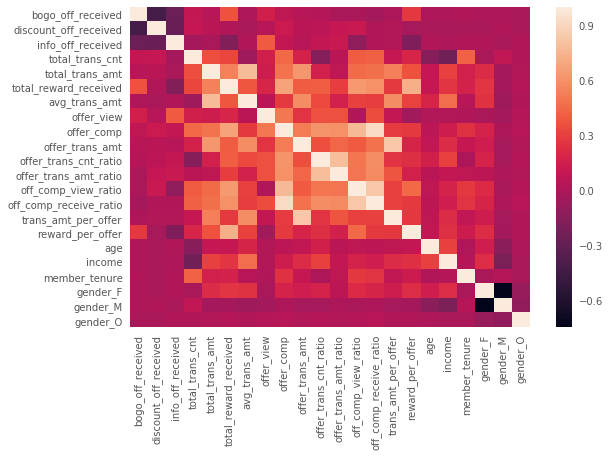

In [274]:
sns.heatmap(X.corr())

#### Feature Importance

Text(0.5, 1.0, 'overall feature importance')

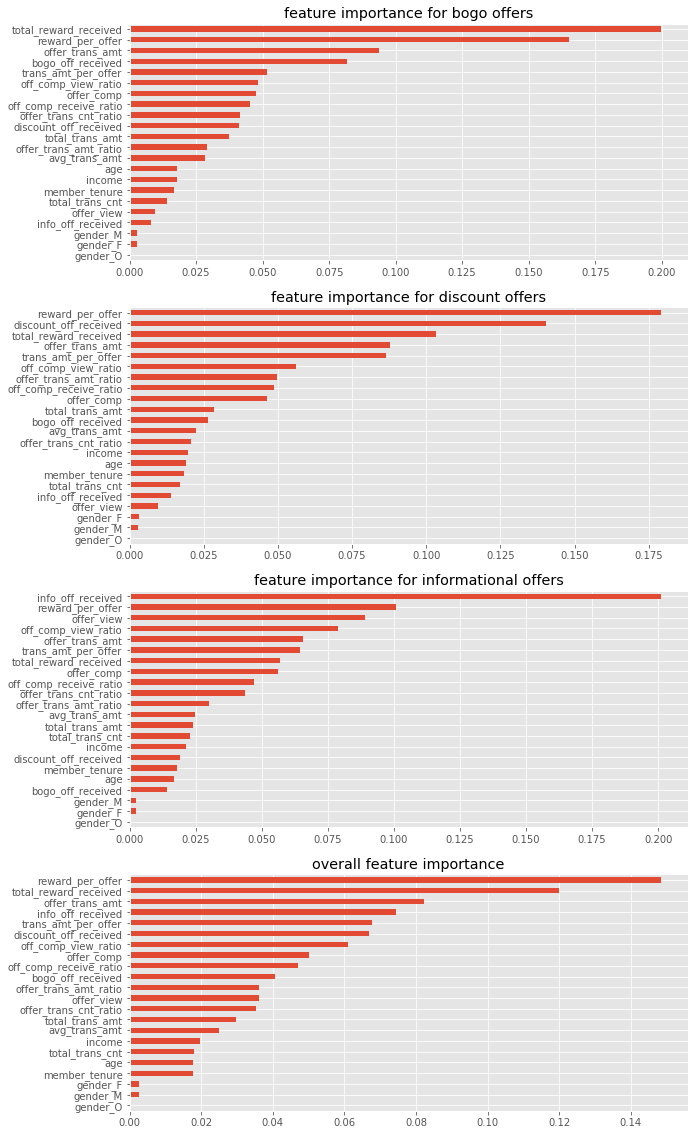

In [71]:
plt.figure(figsize=(10,20))

plt.subplot(4,1,1)
feature_importance_rf = pd.Series(clf.estimators_[0].feature_importances_, index = x_train.columns).sort_values(ascending = True)
feature_importance_rf.plot.barh()
#plt.yticks(fontsize = 10)
plt.title('feature importance for bogo offers')

plt.subplot(4,1,2)
feature_importance_rf = pd.Series(clf.estimators_[1].feature_importances_, index = x_train.columns).sort_values(ascending = True)
feature_importance_rf.plot.barh()
#plt.yticks(fontsize = 10)
plt.title('feature importance for discount offers')

plt.subplot(4,1,3)
feature_importance_rf = pd.Series(clf.estimators_[2].feature_importances_, index = x_train.columns).sort_values(ascending = True)
feature_importance_rf.plot.barh()
#plt.yticks(fontsize = 10)
plt.title('feature importance for informational offers')

# overall
feat_impts = [] 
for mod in clf.estimators_:
    feat_impts.append(mod.feature_importances_)
    
plt.subplot(4,1,4)
feature_importance_rf = pd.Series(np.mean(feat_impts, axis=0), index = x_train.columns).sort_values(ascending = True)
feature_importance_rf.plot.barh()
#plt.yticks(fontsize = 10)
plt.title('overall feature importance')

It seems that `reward_per_offer` and `offer_trans_amt` are the most important features across the board. How is each feature different among the three offer types?

#### Feature Difference by Offer Combination

In [72]:
user_df_final['trans_amt_no_offer'] = user_df_final['total_trans_amt']- user_df_final['offer_trans_amt']
user_df_final['trans_cnt_no_offer'] = user_df_final['total_trans_cnt']- user_df_final['offer_comp']

col_list1 = ['offer_trans_cnt_ratio', 'offer_trans_amt_ratio', 'off_comp_view_ratio', 
       'off_comp_receive_ratio']
col_list2 = ['offer_comp', 'total_trans_cnt', 'trans_cnt_no_offer', 'total_reward_received', 'reward_per_offer']
col_list3 = [ 'total_trans_amt',  'offer_trans_amt',  'trans_amt_per_offer','avg_trans_amt', 'trans_amt_no_offer']
user_df_final[['bogo_offer','discount_offer','information_offer']] = \
            user_df_final[['bogo_offer','discount_offer','information_offer']].astype(int)

In [73]:
def mean_by_offer_type (data, columns):    
    col = columns[0]
    df = data.groupby(['bogo_offer','discount_offer','information_offer'])[col].mean().reset_index()
    for col in columns[1:]:
        curr = data.groupby(['bogo_offer','discount_offer','information_offer'])[col].mean().reset_index()
        df = df.merge(curr, on =['bogo_offer','discount_offer','information_offer'])
    return df

Text(0.5, 1.0, 'Metric Average of Offer Type Combinations')

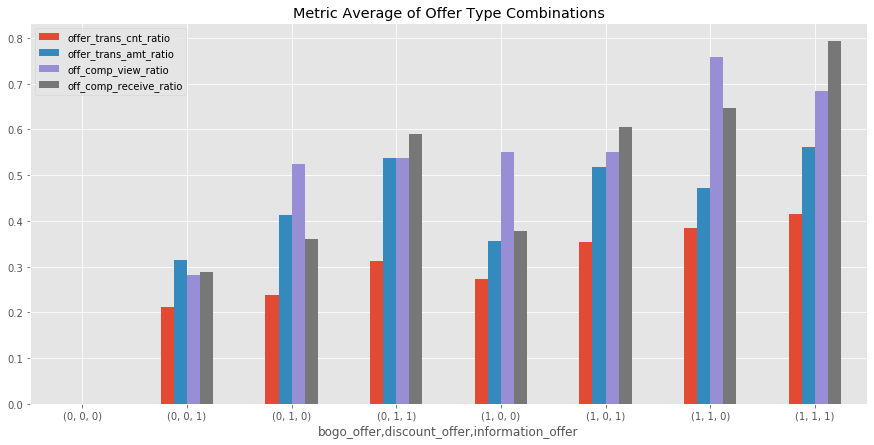

In [74]:
ratio_df = mean_by_offer_type (user_df_final, col_list1)

ratio_df.set_index(['bogo_offer','discount_offer','information_offer']).plot.bar(figsize=(15,7), rot = 0)
plt.title('Metric Average of Offer Type Combinations')

Text(0.5, 1.0, 'Metric Average of Offer Type Combinations')

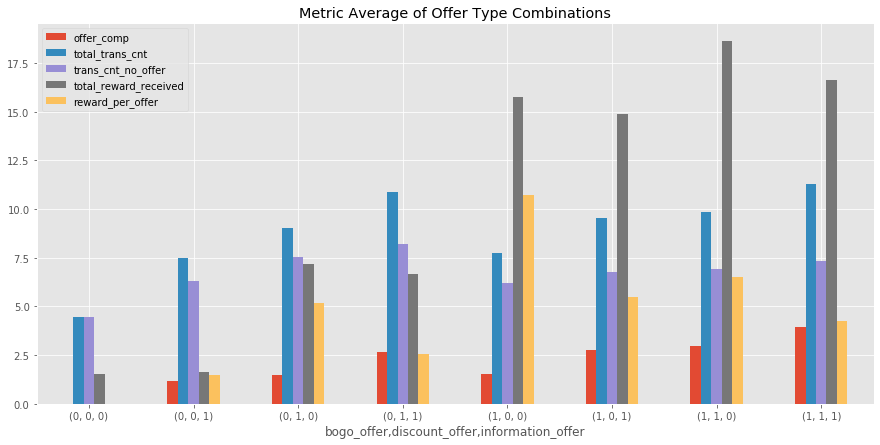

In [75]:
trans_df = mean_by_offer_type (user_df_final, col_list2)

trans_df.set_index(['bogo_offer','discount_offer','information_offer']).plot.bar(figsize=(15,7), rot = 0)
plt.title('Metric Average of Offer Type Combinations')

Text(0.5, 1.0, 'Metric Average of Offer Type Combinations')

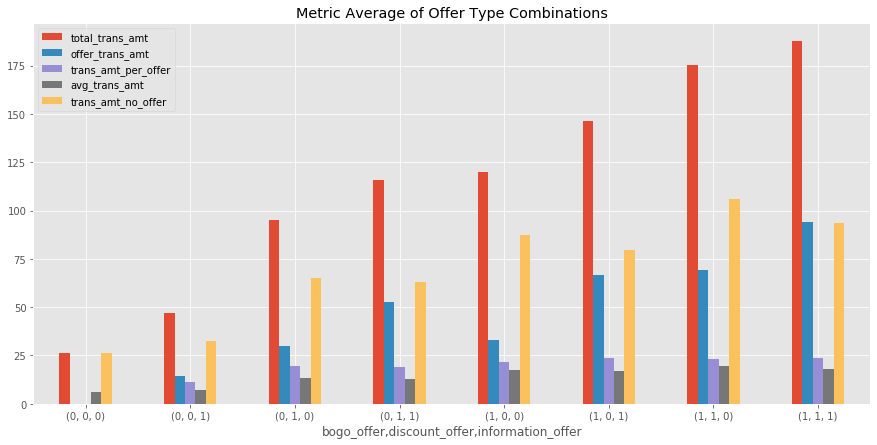

In [76]:
trans_df = mean_by_offer_type (user_df_final, col_list3)

trans_df.set_index(['bogo_offer','discount_offer','information_offer']).plot.bar(figsize=(15,7), rot = 0)
plt.title('Metric Average of Offer Type Combinations')

The labels on the X axis correspond to the three offer types respectively. When it's 1, it means people who use that offer type. eg. (1,1,0) means people who respond to bogo and discount offers but not informational offers.

It's apparent that people who use all three offer types not only spend the most with offers but also have the highest total transaction amount. It means the more we motivate the customers to use the offer, the more likely they spend more in store. 

Also BOGO offer drives more sales than discount and informational offers in general since the right three groups with higher total transaction amount all have responded to bogo offer. It's also worth noting that people who uses bogo and discount offers actually spend more than half of the total transaction amount without offers. Those are Starbuck's most active and valuable customers. It is a positive sign to prove that giving our offers with rewards can indeed improve customers' engagement and as a result, drive sales overall.

Now let's take a look at how the overall offer completion rate, transaction amount ratio motivated by offer, and reward per offer affected by the user demographics.

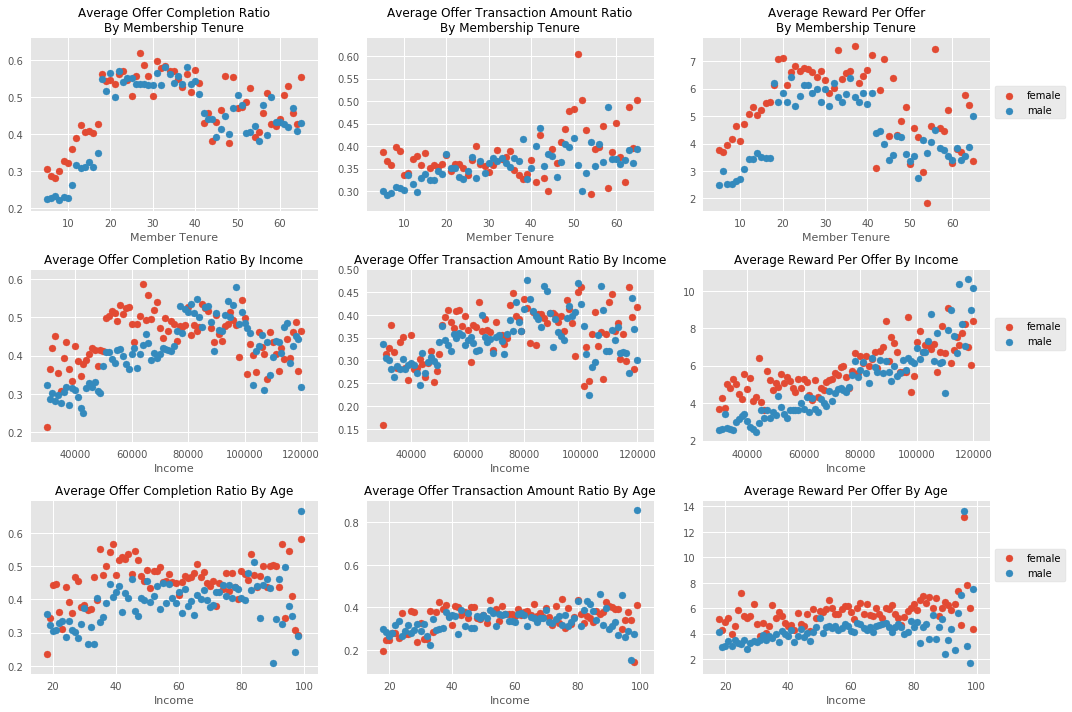

In [300]:
plt.figure(figsize=(15,10))
plt.subplot(3,3,1)
female_avg = user_df_final[user_df_final.gender_F==1].groupby('member_tenure').mean()['off_comp_receive_ratio']
male_avg = user_df_final[user_df_final.gender_M==1].groupby('member_tenure').mean()['off_comp_receive_ratio']
plt.scatter(female_avg.index, female_avg);
plt.scatter(male_avg.index, male_avg);
plt.xlabel('Member Tenure');
plt.title('Average Offer Completion Ratio\nBy Membership Tenure')

plt.subplot(3,3,2)
female_avg = user_df_final[user_df_final.gender_F==1].groupby('member_tenure')['offer_trans_amt_ratio'].mean()
male_avg = user_df_final[user_df_final.gender_M==1].groupby('member_tenure')['offer_trans_amt_ratio'].mean()
plt.scatter(female_avg.index, female_avg);
plt.scatter(male_avg.index, male_avg);
plt.xlabel('Member Tenure');
plt.title('Average Offer Transaction Amount Ratio\nBy Membership Tenure')


plt.subplot(3,3,3)
female_avg = user_df_final[user_df_final.gender_F==1].groupby('member_tenure')['reward_per_offer'].mean()
male_avg = user_df_final[user_df_final.gender_M==1].groupby('member_tenure')['reward_per_offer'].mean()
plt.scatter(female_avg.index, female_avg);
plt.scatter(male_avg.index, male_avg);
plt.xlabel('Member Tenure');
plt.title('Average Reward Per Offer\nBy Membership Tenure')
plt.legend(['female', 'male'], bbox_to_anchor=(1.00, 0.5), loc=3);

plt.subplot(3,3,4)
female_avg = user_df_final[user_df_final.gender_F==1].groupby('income').mean()['off_comp_receive_ratio']
male_avg = user_df_final[user_df_final.gender_M==1].groupby('income').mean()['off_comp_receive_ratio']
plt.scatter(female_avg.index, female_avg);
plt.scatter(male_avg.index, male_avg);
plt.xlabel('Income');
plt.title('Average Offer Completion Ratio By Income')

plt.subplot(3,3,5)
female_avg = user_df_final[user_df_final.gender_F==1].groupby('income')['offer_trans_amt_ratio'].mean()
male_avg = user_df_final[user_df_final.gender_M==1].groupby('income')['offer_trans_amt_ratio'].mean()
plt.scatter(female_avg.index, female_avg);
plt.scatter(male_avg.index, male_avg);
plt.xlabel('Income');
plt.title('Average Offer Transaction Amount Ratio By Income')


plt.subplot(3,3,6)
female_avg = user_df_final[user_df_final.gender_F==1].groupby('income')['reward_per_offer'].mean()
male_avg = user_df_final[user_df_final.gender_M==1].groupby('income')['reward_per_offer'].mean()
plt.scatter(female_avg.index, female_avg);
plt.scatter(male_avg.index, male_avg);
plt.xlabel('Income');
plt.title('Average Reward Per Offer By Income')
plt.legend(['female', 'male'], bbox_to_anchor=(1.00, 0.5), loc=3);


plt.subplot(3,3,7)
female_avg = user_df_final[user_df_final.gender_F==1].groupby('age').mean()['off_comp_receive_ratio']
male_avg = user_df_final[user_df_final.gender_M==1].groupby('age').mean()['off_comp_receive_ratio']
plt.scatter(female_avg.index, female_avg);
plt.scatter(male_avg.index, male_avg);
plt.xlabel('Income');
plt.title('Average Offer Completion Ratio By Age')

plt.subplot(3,3,8)
female_avg = user_df_final[user_df_final.gender_F==1].groupby('age')['offer_trans_amt_ratio'].mean()
male_avg = user_df_final[user_df_final.gender_M==1].groupby('age')['offer_trans_amt_ratio'].mean()
plt.scatter(female_avg.index, female_avg);
plt.scatter(male_avg.index, male_avg);
plt.xlabel('Income');
plt.title('Average Offer Transaction Amount Ratio By Age')


plt.subplot(3,3,9)
female_avg = user_df_final[user_df_final.gender_F==1].groupby('age')['reward_per_offer'].mean()
male_avg = user_df_final[user_df_final.gender_M==1].groupby('age')['reward_per_offer'].mean()
plt.scatter(female_avg.index, female_avg);
plt.scatter(male_avg.index, male_avg);
plt.xlabel('Income');
plt.title('Average Reward Per Offer By Age')
plt.legend(['female', 'male'], bbox_to_anchor=(1.00, 0.5), loc=3);

plt.tight_layout()

Key takeaways from the scatter plots above:
1. Offer completion rate grows steadily as the tenure increases in the beginning, and is at its peak when the user tenures of both gender are between 20-30 months, then it declines a bit as the tenure increase, especially for male customers. In reality, the offer conversion rate would grow as the new users get used to the app and start utilizing the benefits more oftenm. After that phase, the conversion rate becomes plateaued.
2. Offer completion rate also seem to have a positive linear relationship with income before income hits 80000. After that it starts to drop as the income increases. Customers are more inclined to use offers when their incomes are below a certain level. After surpassing that income level, the effect of using an offer on motivating transactions decreases.
3. In general, female customers have a higher offer completion rate than male customers, especially in the early tenure and lower income bucket.
4. Average rewards per offer grows steadily as income increases.
5. Female customers also tend to earn higher rewards per offer across almost the whole spectrum of tenure, age and income. It is partly because females have a higher offer completion rate than males. It also implicates that female users are more prone to use BOGO or discount offers to earn rewards, since informational offer do not give out rewards.

Next I want to check whether different demographic groups respond differently to the three offer types.

In [308]:
import warnings
warnings.filterwarnings("ignore")

user_df_final['bogo_conv_rate'] = user_df_final['bogo_comp']/user_df_final['bogo_off_received']
user_df_final['discount_conv_rate'] = user_df_final['discount_comp']/user_df_final['discount_off_received']
user_df_final['info_conv_rate'] = user_df_final['information_comp']/user_df_final['info_off_received']

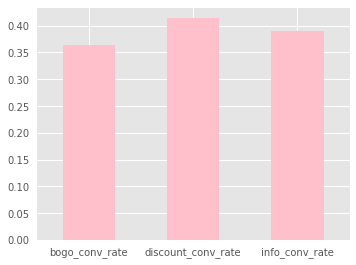

In [313]:
plt.figure(figsize=(5,4))
user_df_final[['bogo_conv_rate', 'discount_conv_rate', 'info_conv_rate']].mean().plot.bar(color='pink',rot=0)

Discount offer has a slightly higher average conversion rate than the other two offer types, making it the most effective offer among three.

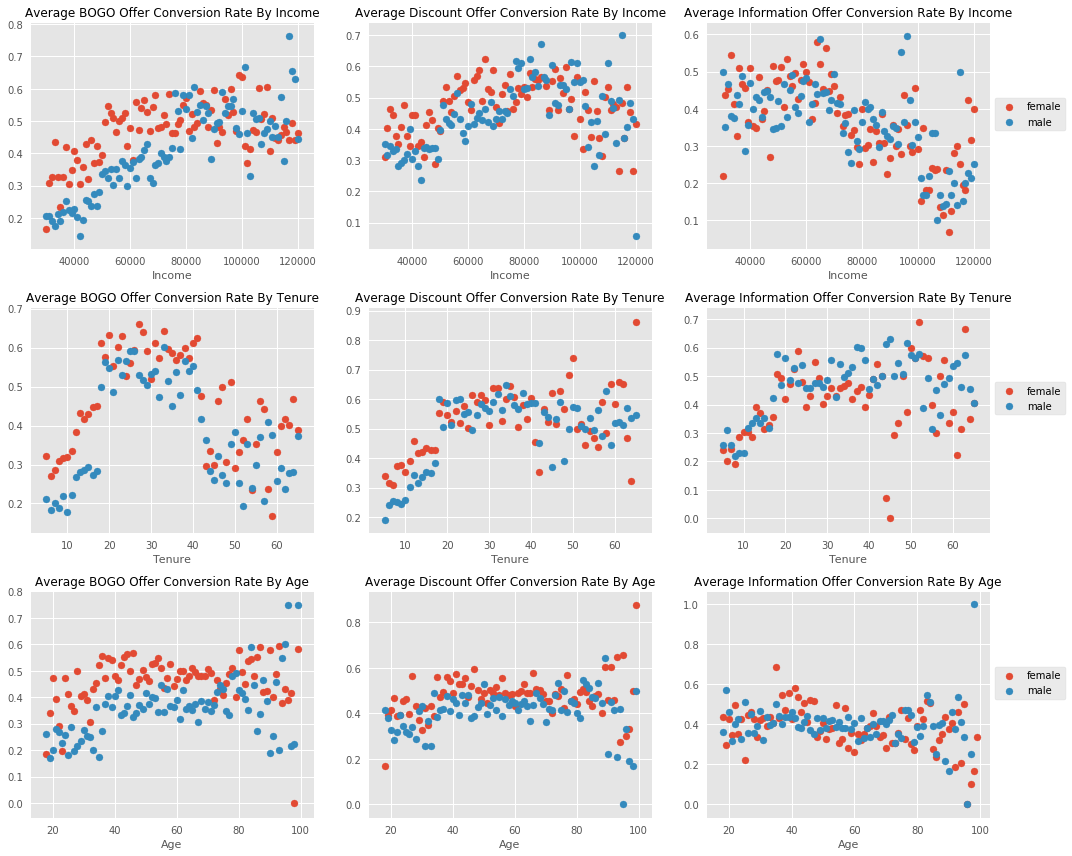

In [298]:
plt.figure(figsize=(15, 12))
plt.subplot(3,3,1)
female_avg = user_df_final[user_df_final.gender_F==1].groupby('income')['bogo_conv_rate'].mean()
male_avg = user_df_final[user_df_final.gender_M==1].groupby('income')['bogo_conv_rate'].mean()
plt.scatter(female_avg.index, female_avg);
plt.scatter(male_avg.index, male_avg);
plt.xlabel('Income');
plt.title('Average BOGO Offer Conversion Rate By Income')

plt.subplot(3,3,2)
female_avg = user_df_final[user_df_final.gender_F==1].groupby('income')['discount_conv_rate'].mean()
male_avg = user_df_final[user_df_final.gender_M==1].groupby('income')['discount_conv_rate'].mean()
plt.scatter(female_avg.index, female_avg);
plt.scatter(male_avg.index, male_avg);
plt.xlabel('Income');
plt.title('Average Discount Offer Conversion Rate By Income')

plt.subplot(3,3,3)
female_avg = user_df_final[user_df_final.gender_F==1].groupby('income')['info_conv_rate'].mean()
male_avg = user_df_final[user_df_final.gender_M==1].groupby('income')['info_conv_rate'].mean()
plt.scatter(female_avg.index, female_avg);
plt.scatter(male_avg.index, male_avg);
plt.xlabel('Income');
plt.title('Average Information Offer Conversion Rate By Income')
plt.legend(['female', 'male'], bbox_to_anchor=(1.00, 0.5), loc=3);

plt.subplot(3,3,4)
female_avg = user_df_final[user_df_final.gender_F==1].groupby('member_tenure')['bogo_conv_rate'].mean()
male_avg = user_df_final[user_df_final.gender_M==1].groupby('member_tenure')['bogo_conv_rate'].mean()
plt.scatter(female_avg.index, female_avg);
plt.scatter(male_avg.index, male_avg);
plt.xlabel('Tenure');
plt.title('Average BOGO Offer Conversion Rate By Tenure')

plt.subplot(3,3,5)
female_avg = user_df_final[user_df_final.gender_F==1].groupby('member_tenure')['discount_conv_rate'].mean()
male_avg = user_df_final[user_df_final.gender_M==1].groupby('member_tenure')['discount_conv_rate'].mean()
plt.scatter(female_avg.index, female_avg);
plt.scatter(male_avg.index, male_avg);
plt.xlabel('Tenure');
plt.title('Average Discount Offer Conversion Rate By Tenure')

plt.subplot(3,3,6)
female_avg = user_df_final[user_df_final.gender_F==1].groupby('member_tenure')['info_conv_rate'].mean()
male_avg = user_df_final[user_df_final.gender_M==1].groupby('member_tenure')['info_conv_rate'].mean()
plt.scatter(female_avg.index, female_avg);
plt.scatter(male_avg.index, male_avg);
plt.xlabel('Tenure');
plt.title('Average Information Offer Conversion Rate By Tenure')
plt.legend(['female', 'male'], bbox_to_anchor=(1.00, 0.5), loc=3);

plt.subplot(3,3,7)
female_avg = user_df_final[user_df_final.gender_F==1].groupby('age')['bogo_conv_rate'].mean()
male_avg = user_df_final[user_df_final.gender_M==1].groupby('age')['bogo_conv_rate'].mean()
plt.scatter(female_avg.index, female_avg);
plt.scatter(male_avg.index, male_avg);
plt.xlabel('Age');
plt.title('Average BOGO Offer Conversion Rate By Age')

plt.subplot(3,3,8)
female_avg = user_df_final[user_df_final.gender_F==1].groupby('age')['discount_conv_rate'].mean()
male_avg = user_df_final[user_df_final.gender_M==1].groupby('age')['discount_conv_rate'].mean()
plt.scatter(female_avg.index, female_avg);
plt.scatter(male_avg.index, male_avg);
plt.xlabel('Age');
plt.title('Average Discount Offer Conversion Rate By Age')

plt.subplot(3,3,9)
female_avg = user_df_final[user_df_final.gender_F==1].groupby('age')['info_conv_rate'].mean()
male_avg = user_df_final[user_df_final.gender_M==1].groupby('age')['info_conv_rate'].mean()
plt.scatter(female_avg.index, female_avg);
plt.scatter(male_avg.index, male_avg);
plt.xlabel('Age');
plt.title('Average Information Offer Conversion Rate By Age')
plt.legend(['female', 'male'], bbox_to_anchor=(1.00, 0.5), loc=3);

plt.tight_layout()

There are couple interesting insights from this set of scatter plots.
1. Both Income and tenure seem to have a noticeable impact on the offer conversion rate while age does not.
2. Female customers show a steadily higher conversion rate for BOGO offer across different age, income and tenure, while informational offer tend to be more effective on male customers among most tenure buckets(plot 6).
3. BOGO offer conversion rate by tenure shows a very similar pattern to the overall offer completion rate- it reaches the peak when users' tenures are between 20-30 months then starts a sharp decline. Discount offer conversion rate on the other hand, shows a stable growth as the tenure increases.
4. BOGO and discount conversion rate both grow as income rises then show a slight decrease after users' income reaches 8000. However, the conversion rate for informational offers keep declining as income grows. This is a very interesting trend and it actually makes sense because unlike bogo and discount offers, informational offers do not have any minimal transaction amount, making the difficulty of using info offer much less than the other two offers. That's why it's more popular among lower income groups. This also explains why the rewards per offer in the previous chart shows a consistent increase as income goes higher - BOGO and discount offers usually come with rewards and a minimal transaction amount to use the offer, thus they are more popular among higher income group.

### Make predictions for the best offer type for any given customers
If the model predicts multiple offer types for the customer, sort the recommendation based on higher probability of conversion.

In [262]:
y_test_prob = np.array(clf.predict_proba(x_test))
y_test_prob.shape
# 3 = 3 target variables(offer types)
# 3400 = number of users in test set
# 2 = prob of binary classes (0/1)

(3, 3400, 2)

In [257]:
def predict_best_offer (user_ids, model):
    '''
    given a list of user_ids, predict the offer type(s) to send to each user.
    If there are more than one offer, the offer type output will be sort by predicted probability in descending order.
    '''
    offer_type = ['bogo','discount','informational']
    pred_prob_all = model.predict_proba(X.loc[user_ids])
    pred_class_all = model.predict(X.loc[user_ids])
    
    # reorganize the array to get the class 1 predicted probability for each offer for each user
    # result: number of rows = number of users provided, columns = prob of class 1 for each offer type
    pred_prob_new = [[pred_prob_all[c][i][1] for c in range(len(offer_type)) ] for i in range(len(user_ids))]

    best_offer = []
    no_offer_id =[]
    pred_prob_new = np.array(pred_prob_new)
    
    for user in range(len(pred_prob_new)):
        if pred_class_all[user].sum()>0:
            pred_class1_idx = np.argwhere(pred_class_all[user]==1).flatten() # get the index where predicted offer = 1     
            prob_idx_sorted = np.argsort(-pred_prob_new[user]) # sort probability in descending order
            best_idx = [i for i in prob_idx_sorted if i in pred_class1_idx]
            best_offer.append([offer_type[i] for i in best_idx])
        else:
            best_offer.append('no offer is recommended for the user')
            
    return best_offer
        

In [258]:
user_ids = np.random.choice(X.index, 20)
result = predict_best_offer (user_ids, clf)

In [259]:
for i in range(len(user_ids)):
    user = user_ids[i]
    print('The best offer type for user {} is : {}'.format(user, result[i]))

The best offer type for user 7c25d44106054da2887c0e8864b71185 is : ['discount', 'bogo']
The best offer type for user 2bb22e7931aa49ebabff26b9cbc6260a is : ['discount', 'informational']
The best offer type for user 4109b7b0a77a4f5ab2d2ae906290110d is : ['discount']
The best offer type for user 8b27a4a3a2454af2999ccf5bb8963ba6 is : ['bogo']
The best offer type for user 1174368d584d4d019b50eae0719b46d1 is : ['discount', 'bogo']
The best offer type for user e6590c7f954f4ff482c069b45070b351 is : ['bogo']
The best offer type for user 63cadfdb7b6f4dcc8603b47c3259348d is : no offer is recommended for the user
The best offer type for user 2d8bf69e95804ebbb1be4f87d7ed387a is : ['discount']
The best offer type for user a092308012d345749be1307a63acbae5 is : ['discount']
The best offer type for user 476bce5ff4194f9cafa2bb4aad0d9ad1 is : no offer is recommended for the user
The best offer type for user 3cabd0099961416b9810043e7eb0f743 is : ['informational', 'discount', 'bogo']
The best offer type fo

## Clustering

After making the predictions for the best offer type to send to each individual customers, I want to know whether there is any generalized patterns of behavioral and demographic attributes for certain subgroups within the whole Starbuck's customer base that set them apart from one another. This way allows us to understand the customers not only on a individual level but also under a market segmentation context that would help devising different marketing strategies towards different customer groups and make targeting more precise and efficient.

In [316]:
user_df_final.fillna(0, inplace=True)
user_df_final.columns

Index(['bogo_off_received', 'discount_off_received', 'info_off_received',
       'total_trans_cnt', 'total_trans_amt', 'total_reward_received',
       'avg_trans_amt', 'offer_view', 'offer_comp', 'discount_comp',
       'offer_trans_amt', 'bogo_comp', 'information_comp', 'bogo_offer',
       'discount_offer', 'information_offer', 'no_offer',
       'offer_trans_cnt_ratio', 'offer_trans_amt_ratio', 'off_comp_view_ratio',
       'off_comp_receive_ratio', 'trans_amt_per_offer', 'reward_per_offer',
       'age', 'income', 'member_tenure', 'gender_F', 'gender_M', 'gender_O',
       'trans_amt_no_offer', 'trans_cnt_no_offer', 'bogo_conv_rate',
       'discount_conv_rate', 'info_conv_rate'],
      dtype='object')

#### Elbow Method to find out best number of clusters

Text(0, 0.5, 'inertia')

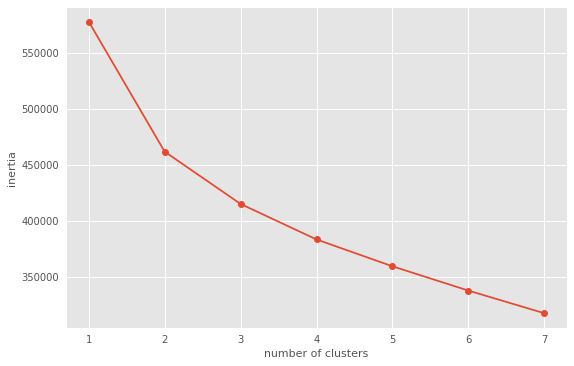

In [348]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
user_df_std = std.fit_transform(user_df_final)

n_clusters = range(1,8)
inertias = []
for k in n_clusters:
    model = KMeans(n_clusters = k)
    model.fit(user_df_std)
    inertias.append(model.inertia_)
    
plt.plot(n_clusters, inertias, '-o')
plt.xlabel('number of clusters')
plt.ylabel('inertia')

In [359]:
km2 = KMeans(n_clusters= 3)
km2.fit(user_df_std)
cluster_assignment2 = pd.DataFrame(std.inverse_transform(user_df_std), columns = user_df_final.columns)
cluster_assignment2['cluster_label'] = km2.labels_ 
cluster_center2 = pd.DataFrame(km2.cluster_centers_, columns = user_df_final.columns)

In [379]:
cluster_assignment2['cluster_label'].value_counts()

0    7178
1    5720
2    4102
Name: cluster_label, dtype: int64

In [380]:
cluster_center2_inv = pd.DataFrame(std.inverse_transform(cluster_center2), columns = user_df_final.columns)

In [381]:
cluster_center2_inv[['offer_trans_cnt_ratio', 'offer_trans_amt_ratio', 'off_comp_view_ratio',
       'off_comp_receive_ratio', 'trans_amt_per_offer', 'reward_per_offer',
       'age', 'income', 'member_tenure', 'gender_F', 'gender_M', 'gender_O',
       'trans_amt_no_offer', 'trans_cnt_no_offer', 'bogo_conv_rate',
       'discount_conv_rate', 'info_conv_rate']]

,offer_trans_cnt_ratio,offer_trans_amt_ratio,off_comp_view_ratio,off_comp_receive_ratio,trans_amt_per_offer,reward_per_offer,age,income,member_tenure,gender_F,gender_M,gender_O,trans_amt_no_offer,trans_cnt_no_offer,bogo_conv_rate,discount_conv_rate,info_conv_rate
0,0.318228,0.419784,0.656939,0.504498,22.599114,7.528695,56.222625,70407.077180,24.640150,0.462664,0.482307,0.014628,95.153590,7.017693,0.493322,0.537819,0.000070
1,0.053269,0.100393,0.084106,0.068327,2.235676,0.576647,52.233700,58923.614753,16.587834,0.199965,0.516169,0.008390,22.878764,4.953155,0.013949,0.052654,0.116078
2,0.349771,0.527457,0.564800,0.637028,22.284596,3.892938,54.338942,64946.354548,25.718361,0.405755,0.504511,0.014387,76.433426,7.463545,0.449138,0.496164,0.841169


In [382]:
cluster_center2_inv[['bogo_off_received', 'discount_off_received', 'info_off_received',
       'total_trans_cnt', 'total_trans_amt', 'total_reward_received',
       'avg_trans_amt', 'offer_view', 'offer_comp', 'discount_comp',
       'offer_trans_amt', 'bogo_comp', 'information_comp', 'bogo_offer',
       'discount_offer', 'information_offer', 'no_offer']]

,bogo_off_received,discount_off_received,info_off_received,total_trans_cnt,total_trans_amt,total_reward_received,avg_trans_amt,offer_view,offer_comp,discount_comp,offer_trans_amt,bogo_comp,information_comp,bogo_offer,discount_offer,information_offer,no_offer
0,1.953330,1.986347,0.496935,9.201588,144.985371,14.984954,18.451057,3.560741,2.183895,1.141404,49.831780,1.042352,0.000139,0.690025,0.740178,0.000139,8.358874e-04
1,1.763153,1.703374,0.883237,5.249782,25.114440,1.643419,5.353464,3.369691,0.296626,0.109946,2.235676,0.033036,0.153644,0.033036,0.109946,0.153644,7.033735e-01
2,1.558400,1.594733,1.613021,10.453548,144.127596,11.634236,15.538203,5.369910,2.990002,0.920507,67.694170,0.831261,1.238235,0.576445,0.640088,0.999756,2.636780e-15


### Cluster Visualization

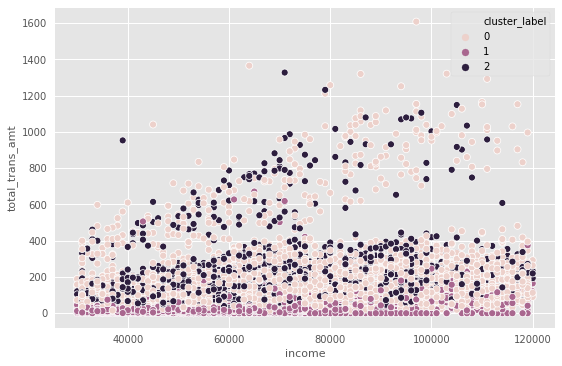

In [360]:
sns.scatterplot(cluster_assignment2['income'], cluster_assignment2['total_trans_amt'], hue= cluster_assignment2['cluster_label'])


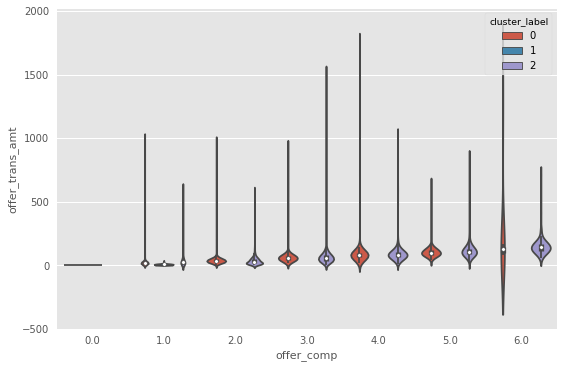

In [391]:
sns.violinplot(cluster_assignment2['offer_comp'], cluster_assignment2['offer_trans_amt'], hue= cluster_assignment2['cluster_label'])

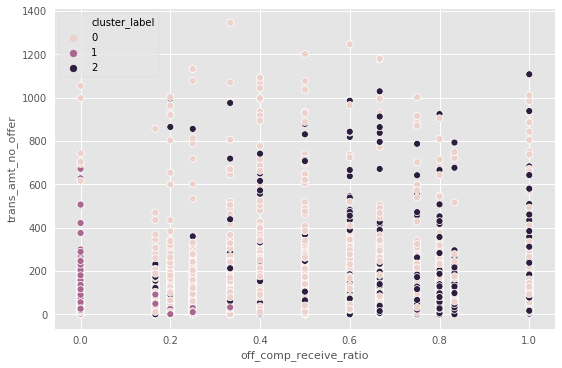

In [401]:
sns.scatterplot(cluster_assignment2['off_comp_receive_ratio'], cluster_assignment2['trans_amt_no_offer'][cluster_assignment2['trans_amt_no_offer']>=0], \
                hue= cluster_assignment2['cluster_label'])

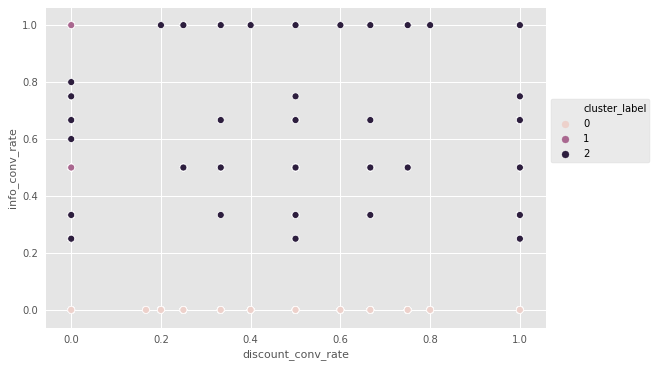

In [374]:
sns.scatterplot(cluster_assignment2['discount_conv_rate'], cluster_assignment2['info_conv_rate'], hue= cluster_assignment2['cluster_label'])
plt.legend(bbox_to_anchor=(1.00, 0.5), loc=3);


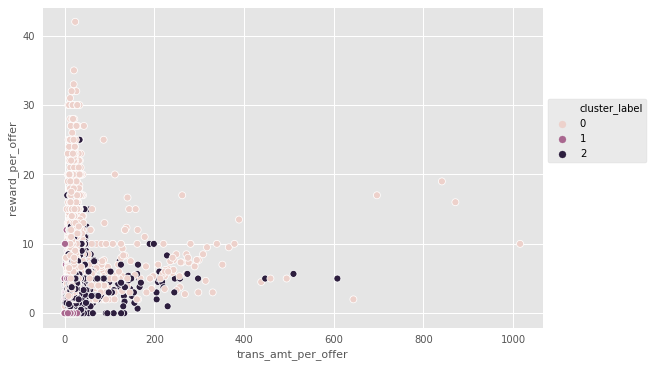

In [378]:
sns.scatterplot(cluster_assignment2['trans_amt_per_offer'], cluster_assignment2['reward_per_offer'], hue= cluster_assignment2['cluster_label'])
plt.legend(bbox_to_anchor=(1.00, 0.5), loc=3);

### Cluster Descriptions 
From the visualizations above together with cluster centers, we can see each cluster has a set of distinct attributes in their transational behaviors and reactions to different offers, although they share very similar demographics in terms of age, income and member tenure.


* Cluster 0 : this group is highly motivated by rewards offers such as discount and BOGO, almost never respond to informational offers. They have the highest average income and have similar total transaction amount as cluster 2. Though they may not have as high offer completion rate as cluster 2, they spend actually more without offer than with offer. This group is Starbuck's regulars who spend the most on average and the best effective offers for them are discount and then bogo offers.


* Cluster 1: this group is mostly dormant accounts, they are in general infrequent shoppers and are not responsive to offers, also transact much less than the other two groups. In fact, a lot of them in this group are labels as "no offer" customers. They use the Starbucks app now and then but definitely are not the core customer base for Starbucks.


* Cluster 2: this last cluster is another active group who has the highest offer completion rate overall among the three. The biggest difference between cluster 0 and cluster 2 is that this group has a very high informational offer conversion rate, although the bogo and discount offer conversion rates are lower than the cluster 0. This signifies that this group of customers are more prone to use offers with no minimal transaction restrictions and we may want to prioritize sending them offers with lower difficulty threshold that they are more likely to use. So the order of offer type to send might be informational -> discount -> BOGO. 

## Further Improvements
This project can be taken one more step further to predict the exact offers to recommend to each customers, eg. send discount offer of diffculty(min transaction) 20 to uesr A, BOGO offer of diffculty 10 to user B using the exact same set of features with an additional offer difficulty attribute. 

Doing that would take the offer personalization to a greater granular level, especially considering that the minimal transaction amount threshold plays a big role in whether the user responds to the offer or not. Some discount offers have pretty high threshold of transaction, so they might not be the best offer to send to people who do not have high average spend tend to only use offers with low difficulties. 

We can also confirm if the cluserting result is accurate by cross checking for example, whether the classification model does recommend informational offer to users in cluster 2. If the result is satisfying, the fitted clustering model can be used as the first pass for market segmentation before enough data can be collected for offer personalization.

The more we study customers behaviors, the better we can get at sending personalized offers that yield higher conversion rate, and the higher the customer engagement and user stickiness will be. This is the goal most of the businesses are striving towards.